### What impact does perceived safety have on livability in urban neighborhoods? What physical and socioeconomic factors drive the perception of safety of urban streetscapes?

#### Table of Contents
[1. Import modules and load pickled files](#1)  
[2. Normalize perceived danger and actual crime scores](#2)  
[3. Identify neighborhoods with high differences in actual vs. perceived scores](#3)  
[4. Cluster neighborhoods based on difference scores and variance](#4)  
[5. Investigate impacts of differences in perceived v. actual crime](#5)

### <a id='1'></a> 1. Import necessary modules and load pickled files

In [327]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm, tqdm_pandas
import matplotlib.pyplot as plt
import seaborn as sns
import math
% matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

from sklearn.cluster import KMeans, DBSCAN

import pysal # spatial autocorrelation

In [3]:
with open('data/pickled/ss_orig_nyc.pkl', 'r') as picklefile:
    sso = pickle.load(picklefile)
    
with open('data/pickled/ss_withzip.pkl', 'r') as picklefile:
    ssp = pickle.load(picklefile)
    
with open('data/pickled/crime_withzip.pkl', 'r') as picklefile:
    crime = pickle.load(picklefile)

In [4]:
# split crime data into relevant years for sso and ssp data
crime2010 = crime[crime['Occurrence Year'] == 2010]

In [5]:
crime2014 = crime[crime['Occurrence Year'] == 2014]

### <a id='2'></a> 2. Normalize perceived danger and crime scores

#### Perceived safety/crime scores

Normalize q-scores to 0-10 range.

In [6]:
def normalize(df, score_col, norm_col, range_start = 0, range_end = 10):
    min_score = float(df[score_col].min())
    max_score = float(df[score_col].max())
    range_start = float(range_start)
    range_end = float(range_end)
    norm_func = lambda score: range_start + (float(score) - min_score) * (range_end - range_start) / (max_score - min_score)
    normalized = [norm_func(score) for score in df[score_col].tolist()]
    df.loc[:, norm_col] = normalized

In [7]:
normalize(ssp, 'q-score', 'q_norm')
normalize(sso, 'QS Safer', 'q_norm')

Convert/invert q-score of safety to danger score.

In [8]:
# invert normalized scores
normalize(ssp, 'q-score', 'q_norm_rev', range_start = 10, range_end = 0)
normalize(sso, 'QS Safer', 'q_norm_rev', range_start = 10, range_end = 0)

In [9]:
# invert original (non-normalized socres)
normalize(ssp, 'q-score', 'danger_score_raw', range_start = max(ssp['q-score']), range_end = min(ssp['q-score']))
normalize(sso, 'QS Safer', 'danger_score_raw', range_start = max(sso['QS Safer']), range_end = min(sso['QS Safer']))

Get average q-score by zip code.

In [10]:
def agg_qscores(df, geo_col, score_col):
    grouped = df.groupby(geo_col)
    scores = pd.DataFrame(grouped[score_col].mean())
    return scores

In [11]:
ssbyzcta = agg_qscores(ssp, 'zcta', 'q_norm')
ss_orig_byzcta = agg_qscores(sso, 'zcta', 'q_norm')

In [12]:
ssbyz_danger = agg_qscores(ssp, 'zcta', 'q_norm_rev')
ssorigbyz_danger = agg_qscores(sso, 'zcta', 'q_norm_rev')

Get average q-score by Census tract.

In [13]:
# perceived safety
ss_by_ct = agg_qscores(ssp, 'fips_tract', 'q_norm')
ssorig_by_ct = agg_qscores(sso, 'fips_tract', 'q_norm')

In [14]:
# perceived crime
ssp_by_ct = agg_qscores(ssp, 'fips_tract', 'q_norm_rev')
sso_by_ct = agg_qscores(sso, 'fips_tract', 'q_norm_rev')

Map to shape file census tract.

In [15]:
with open('data/pickled/TRACT_DICT.pkl', 'r') as picklefile:
    tract_dict = pickle.load(picklefile)

In [16]:
# get truncated tract numbers
ssp_by_ct['tract_copy'] = ssp_by_ct.index.values
ssp_by_ct['tract_short'] = ssp_by_ct.tract_copy.apply(lambda x: tract_dict[x] if x in tract_dict else '')
ssp_by_ct.head()

q_norm_rev   tract_copy tract_short
fips_tract                                      
36005000200    3.726878  36005000200     2000200
36005000400    4.086433  36005000400     2000400
36005001600    3.971630  36005001600     2001600
36005001900    4.954953  36005001900     2001900
36005002000    3.646495  36005002000     2002000

Export for cartodb viz

In [19]:
def zip_to_cartodb(df, path):
    df['country'] = 'United States'
    df.to_csv(path)

In [20]:
def tract_to_cartodb(df, path):
    df['tract_copy'] = df.index.values
    df['tract_short'] = df.tract_copy.apply(lambda x: tract_dict[x] if x in tract_dict else '')
    df.drop('tract_copy', axis = 1, inplace = True)
    df.to_csv(path, index = False)

In [115]:
tract_to_cartodb(ssp_by_ct, 'data/for_cartodb/ss_by_ct.csv')

In [145]:
tract_to_cartodb(sso_by_ct, 'data/for_cartodb/ssorig_by_ct.csv')

In [707]:
zip_to_cartodb(ssbyzcta, 'data/for_cartodb/ss_by_zcta.csv')
zip_to_cartodb(ss_orig_byzcta, 'data/for_cartodb/ssorig_by_zcta.csv')

In [711]:
zip_to_cartodb(ss_by_ct, 'data/for_cartodb/ss_by_tract.csv')
zip_to_cartodb(ssorig_by_ct, 'data/for_cartodb/ssorig_by_tract.csv')

#### Actual crime scores

In [21]:
def get_crimes_by_geo(df, geo_col):
    """Given original crimes df, return df of counts by crime type by chosen geography."""
    byzip = df.groupby([geo_col, 'Offense'])
    crimesdf = byzip.OBJECTID.count().unstack(level=-1)
    crimesdf.fillna(0, inplace = True)
    crimesdf['total'] = crimesdf.sum(axis = 1)
    crimesdf[geo_col] = crimesdf.index
    return crimesdf

In [22]:
# def clean_acs(df, geo_col, data_col, geo_col_name):
#     """Given ACS zcta data file, return dictionary with key = zcta and values = data."""
#     df[geo_col_name] = df[geo_col].apply(lambda x: int(x.split()[1]) if len(x.split()) > 1 else x)
#     data_dict = dict(zip(df[geo_col_name].values, df[data_col].values.tolist()))
#     return data_dict

def add_acs_data(acs_df, acs_geo_col, acs_data_col, df, df_geo_col, df_new_data_name):
    """Given ACS zcta data file, return dictionary with key = geography and values = data."""
    # create dictionary of {geo: value} from acs data
    data_dict = dict(zip(acs_df[acs_geo_col].values, acs_df[acs_data_col].values.tolist()))
    
    # fetch value for key and add to df 
    df[df_new_data_name] = df.loc[:, df_geo_col].apply(lambda x: int(data_dict[x]) if x in data_dict else np.nan)

In [17]:
# def clean_acs_df(df, zcta_col, data_col):
#     """Given ACS zcta data file, return df of relevant data."""
#     df['zcta'] = df[zcta_col].apply(lambda x: int(x.split()[1]) if len(x.split()) > 1 else x)
#     keep = data_col + ['zcta']
#     return df[keep]

In [ ]:
"""normalizing crime:
- crime rate - crime per 100,000 residents
- great post: http://opendata.stackexchange.com/questions/381/how-to-normalize-the-data-when-mapping-crime-reports
"""

#### Clean crimes df v2 for 2010 data - hopefully cleaner!

In [31]:
# fetch resident and worker population data
pop2010 = pd.read_csv('data/dem_data/census_pop_by_bg_2010.csv')
workers2010 = pd.read_csv('data/dem_data/lehd_workers_2010.csv')
workers = pd.read_csv('data/dem_data/lehd_workers_2014.csv')
pop2014 = pd.read_csv('data/dem_data/acs_pop_by_bg_2014.csv')

In [25]:
# fetch block group shape file reference data
with open('data/pickled/BLOCKGROUP_DF.pkl', 'r') as picklefile:
    bg_df = pickle.load(picklefile)

In [26]:
def get_workers_by_bg(df):
    """Given df of lehd data, return df of total workers per block group."""
    df['block_group'] = df.loc[:, 'w_geocode'].apply(lambda x: str(x)[:12])
    by_bg = df.groupby('block_group')
    newdf = pd.DataFrame(by_bg['C000'].sum())
    newdf['block_group'] = newdf.index
    newdf.rename(columns = {'C000': 'total_workers'}, inplace = True)
    return newdf

In [27]:
def combine_workers_crime(wdf, cdf):
    worker_dict = dict(zip(wdf.block_group, wdf.total_workers))
    cdf['workers'] = cdf.fips_bg.apply(lambda x: worker_dict[x] if x in worker_dict else np.nan)

In [28]:
def normalize_crime(cdf, pdf, wdf):
    cdf2 = get_crimes_by_geo(cdf, 'fips_bg')
    wdf2 = get_workers_by_bg(wdf)
    combine_workers_crime(wdf2, cdf2)
    try:
        add_acs_data(pdf, 'GEO.id2', 'D001', cdf2, 'fips_bg', 'residents')
    except:
        add_acs_data(pdf, 'GEO.id2', 'HD01_VD01', cdf2, 'fips_bg', 'residents')
    
    # get combined population
    cdf2['total_pop'] = cdf2.loc[:, 'workers'] + cdf2.loc[:, 'residents']
    cdf2.dropna(inplace = True)
    
    # divide total crime by population
    cdf2['all_crimes_rate'] = cdf2.loc[:, 'total'] / cdf2.loc[:, 'total_pop'] * 1000
    
    # add geo area
    bg_dict = dict(zip(bg_df.GEOID10, bg_df.ALAND10))
    cdf2['area'] = cdf2.loc[:, 'fips_bg'].apply(lambda x: bg_dict[x] if x in bg_dict else np.nan)
    
    # only keep groups with total pop > 100
    cdf2 = cdf2[cdf2.total_pop > 100]
    
    return cdf2

In [32]:
crime2010_bg = normalize_crime(crime2010, pop2010, workers2010)
crime2014_bg = normalize_crime(crime2014, pop2014, workers)

#### Normalize crime data by converting raw crime count to crime rates based on census tract worker and resident population.

Two ways of normalizing: 
* by resident and worker population in that geography
* by physical area of the geography

In [33]:
# get dataframe of crimes by geography
crime2014_ct = get_crimes_by_geo(crime2014, 'fips_tract')

Normalize by worker and resident population.

In [34]:
# fetch population data
pop_ct = pd.read_csv('data/dem_data/acs_pop_by_ct_2014.csv')

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (1,3,4,5,7,8,11,12,15,16,19,20,23,24,27,28,31,32,35,36,39,40,43,44,47,48,51,52,55,56,59,60,63,64,71,72,75,76,79,80,83,84,87,88,89,91,92,95,96,99,100,101,103,104,107,108,111,112,113,115,116,119,120,123,124,127,128,131,132,135,136,139,140,143,144,147,148,151,152,155,156,159,160,163,164,167,168,171,172,175,176,179,180,183,184,187,188,191,192,195,196,199,200,203,204,207,208,211,212,215,216,219,220,223,224,227,228,231,232,233,235,236,239,240,243,244,247,248,251,252,255,256,259,260,261,263,264,267,268,271,272,275,276,279,280,283,284,287,288,291,292,295,296,299,300,303,304,307,308,311,312,315,316,319,320,323,324) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [35]:
add_acs_data(pop_ct, 'GEO.id2', 'HC01_VC03', crime2014_ct, 'fips_tract', 'population')

In [36]:
# add census tract to worker data
workers['tract'] = workers.w_geocode.apply(lambda x: str(x)[:12])

In [37]:
def clean_workers(df):
    """Given lehd df of worker by geo data, return df with workers aggregated by census tract."""
    df['tract'] = df.w_geocode.apply(lambda x: str(x)[:11])
    by_tract = df.groupby('tract')
    newdf = pd.DataFrame(by_tract['C000'].sum())
    newdf['tract'] = newdf.index
    newdf.rename(columns = {'C000': 'total_workers'}, inplace = True)
    return newdf

In [38]:
workers2 = clean_workers(workers)

In [39]:
# add worker data to crime df
worker_dict = dict(zip(workers2.tract, workers2.total_workers))
crime2014_ct['workers'] = crime2014_ct.fips_tract.apply(lambda x: worker_dict[x] if x in worker_dict else np.nan)

In [40]:
# add resident and worker population
crime2014_ct['total_pop'] = crime2014_ct.loc[:,'population'] + crime2014_ct.loc[:, 'workers']

In [41]:
crime2014_ct.dropna(inplace = True) # drop tracts with missing pop or worker counts

In [42]:
crime2014_ct = crime2014_ct[crime2014_ct.total_pop > 1000] # remove tracts with total pop < 1000
crime2014_ct['crime_rate_pop'] = (crime2014_ct.total / crime2014_ct.total_pop) * 1000

In [43]:
# normalize crime rate to be between 0 and 10 
normalize(crime2014_ct, 'crime_rate_pop', 'crime_rate_pop_norm')

Normalize by census tract size.

In [44]:
# pull in detailed census tract data
with open('data/pickled/TRACT_DF.pkl', 'r') as picklefile:
    tract_df = pickle.load(picklefile)

In [45]:
# normalize crime by census tract size
ct_size = dict(zip(tract_df.fips.values, tract_df.Shape_Area))
crime2014_ct['tract_area'] = crime2014_ct.fips_tract.apply(lambda x: ct_size[x] if x in ct_size else 'no data')

In [46]:
# divide crime count per tract by shape area -- what are the units??
crime2014_ct['crime_rate_area'] = (crime2014_ct.total / crime2014_ct.tract_area) * 100000

In [47]:
# normalize crime rate by area to 0-10 scale
normalize(crime2014_ct, 'crime_rate_area', 'crime_rate_area_norm')

#### Export crime data to cartodb for viz

In [ ]:
# raw crime counts, crime rate by population, and crime rate by tract area
crime_cartodb = crime2014_ct[['total', 'crime_rate_pop', 'crime_rate_pop_norm', 'crime_rate_area', 'crime_rate_area_norm']]
tract_to_cartodb(crime_cartodb, 'data/for_cartodb/crime_by_tract2.csv')

#### Compare crime vs. perceived safety - strict comparsion of different scores

Methodology:
1. Normalize perceived and actual scores between 0-10 range.
2. Two methods of determining difference:
    - strict difference between the two scores
    - ratio between the two scores
    
This method is somewhat problematic since we're assuming that the perceived score is measured in the same unit as the actual crime score. This method captures more of the rank of the particular neighborhood within that score against the other neighborhoods instead of actually comparing the two statistics within the same neighborhood.

In [48]:
def compare_crime(ssdf, crimedf):
    """Aggregate streetscore (perceived) and actual crime data for comparison."""
    # merge dataframes and clean up columns
    merged = ssdf.merge(crimedf, left_index = True, right_index = True)
    keep = ['fips_tract', 'q_norm_rev', 'total', 'crime_rate_pop', 'crime_rate_pop_norm', \
            'crime_rate_area', 'crime_rate_area_norm']
    newdf = merged[keep]
    newdf.rename(columns = {'q_norm_rev': 'perceived_danger', 'total': 'raw_crime_count'} , inplace = True)
    
    # add comparison scores
    # straight difference
    newdf['per_act_diff'] = newdf.loc[:, 'perceived_danger'] - newdf.loc[:, 'crime_rate_pop_norm'] 
    
    # ratio between perceived and actual rate 
    newdf['per_act_ratio'] = newdf.loc[:, 'perceived_danger'] / newdf.loc[:, 'crime_rate_pop_norm']
    
    return newdf

In [49]:
ratios = compare_crime(ssp_by_ct, crime2014_ct)

//anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [280]:
tract_to_cartodb(ratios, 'data/for_cartodb/crime_by_tract3.csv')

### <a id='3'></a> 3. Identify areas with high differences by testing ability of crime rate to predict perceived danger (using regression model)
Since the perceived scores are almost a black box in the sense that we cannot map them to actual number of crimes, let's build a regression model to idenfity the "average" relationship between perceived danger and actual crime rates. Once we've identified this mean, we can identify areas that are above and below this mean, and therefore have differences in perceived vs. actual crime rates that deviate from the typical relationship. 

This will also allow us to begin to identify the socioeconomic factors that might lead to different perceptions of safety of urban streetscapes

In [ ]:
"""
next steps
- build regression model to try and predict perceived safety score by image 
- see if actual crime rates can predict perceived safety score -- answer the question of whether or not people perceive crime based on actual crime
- see if other features can predict perceived crime, such as zoning, construction permits, etc. 
"""

In [ ]:
# check if smaller geographies are available for dem data - census block group?

Prep data for linear regression.

In [50]:
def get_log(stat):
    if stat > 0:
        return math.log(stat)
    elif stat == 0:
        return math.log(stat + .001)
    else:
        return math.log(1 + stat)

In [51]:
def log_transform(col_name, df):
    df[col_name + '_log'] = df.loc[:, col_name].apply(lambda x: get_log(x))

In [52]:
# clean up crime df a bit
def clean_crimedf_for_ols_2010(df):
    """Given crime by census tract df, clean up columns and get crime rates by crime types."""
    newdf = df.rename(columns = {'BURGLARY': 'burglary', 
                         'FELONY ASSAULT': 'felony_assault', 'GRAND LARCENY': 'grand_larceny', 
                         'GRAND LARCENY OF MOTOR VEHICLE': 'grand_larceny_mv', 
                         'MURDER & NON-NEGL. MANSLAUGHTE': 'murder', 
                         'RAPE': 'rape', 
                         'ROBBERY': 'robbery',
                         'total': 'all_crimes'})
    
    # add log of total crime rates
    newdf['all_crimes_rate_log'] = np.log(newdf.loc[:, 'all_crimes_rate'])
    
    # add crime rates
    crime_types = ['burglary', 'felony_assault', 'grand_larceny', 'murder', 'rape', 'robbery']
    for c in crime_types:
        newdf[c + '_rate'] = newdf.loc[:, c] / newdf.loc[:, 'total_pop'] * 1000
        log_transform(c + '_rate', newdf) 
        
    # add population density
    newdf['resident_density'] = newdf.loc[:, 'residents'] / newdf.loc[:, 'area']
    newdf['worker_density'] = newdf.loc[:, 'workers'] / newdf.loc[:, 'area']
    
    # add log of population density
    log_transform('resident_density', newdf)
    log_transform('worker_density', newdf)
    
    return newdf

def clean_crimedf_for_ols_2014(df):
    """Given crime by census tract df, clean up columns and get crime rates by crime types."""
    newdf = df.rename(columns = {'BURGLARY': 'burglary', 
                         'FELONY ASSAULT': 'felony_assault', 'GRAND LARCENY': 'grand_larceny', 
                         'GRAND LARCENY OF MOTOR VEHICLE': 'grand_larceny_mv', 
                         'MURDER & NON-NEGL. MANSLAUGHTE': 'murder', 
                         'RAPE': 'rape', 
                         'ROBBERY': 'robbery',
                         'total': 'all_crimes',
                         'crime_rate_pop': 'all_crimes_rate',
                         'population': 'residents'})
    drop = ['crime_rate_area', 'crime_rate_area_norm']
    newdf.drop(drop, axis = 1, inplace = True)
    
    # add log of total crime rates
    newdf['all_crimes_rate_log'] = np.log(newdf.loc[:, 'all_crimes_rate'])
    
    # add crime rates
    crime_types = ['burglary', 'felony_assault', 'grand_larceny', 'murder', 'rape', 'robbery']
    for c in crime_types:
        newdf[c + '_rate'] = newdf.loc[:, c] / newdf.loc[:, 'total_pop'] * 1000
        log_transform(c + '_rate', newdf) 
        
    # add population density
    newdf['resident_density'] = newdf.loc[:, 'residents'] / newdf.loc[:, 'tract_area']
    newdf['worker_density'] = newdf.loc[:, 'workers'] / newdf.loc[:, 'tract_area']
    
    # add log of population density
    log_transform('resident_density', newdf)
    log_transform('worker_density', newdf)
    
    return newdf

In [53]:
# clean up image data dfs a bit
def clean_sspdf_for_ols(df):
    """Clean predicted streetscore column."""
    drop = ['zipcode', 'q-score', 'q_norm', 'fips_detail']
    newdf = df.drop(drop, axis = 1)
    newdf.rename(columns = {'q_norm_rev': 'danger_score_norm'}, inplace = True)
    return newdf

def clean_ssodf_for_ols(df):
    """Clean original streetscore column."""
    keep = ['Lat', 'Lon', 'zcta', 'fips_bg', 'fips_tract', 'q_norm_rev', 'danger_score_raw']
    newdf = df[keep]
    newdf.rename(columns = {'Lat': 'latitude', 'Lon': 'longitude', 'q_norm_rev': 'danger_score_norm'}, inplace = True)
    return newdf

In [54]:
# clean up dfs
crime_ols_2014 = clean_crimedf_for_ols_2010(crime2014_bg)
crime_ols_2010 = clean_crimedf_for_ols_2010(crime2010_bg)
ssp_ols = clean_sspdf_for_ols(ssp)
sso_ols = clean_ssodf_for_ols(sso)

In [55]:
# merge with crime data; inner join to remove data pts without crime data
ssp_ols = ssp_ols.merge(crime_ols_2014, left_on = 'fips_bg', right_on = 'fips_bg')
sso_ols = sso_ols.merge(crime_ols_2010, left_on = 'fips_bg', right_on = 'fips_bg')

Some quick plots to investigate data distribution.

In [56]:
def plot_scatter(x_col, y_col, df):
    """Make a scatter plot!"""
    plt.scatter(df[x_col], df[y_col], alpha = 0.5)
    plt.title('%s vs. %s' %(x_col, y_col))
    plt.xlabel('%s' %x_col)
    plt.ylabel('%s' %y_col)
    plt.show()

In [57]:
def plot_scatter_eval(x_col, y_col, df):
    """Make a scatter plot for model evaluation."""
    plt.scatter(df[x_col], df[y_col], alpha = 0.5)
    plt.title('%s vs. %s: MSE = %f' %(x_col, y_col, mean_squared_error(df[x_col], df[y_col])))
    plt.xlabel('%s' %x_col)
    plt.ylabel('%s' %y_col)
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.show()

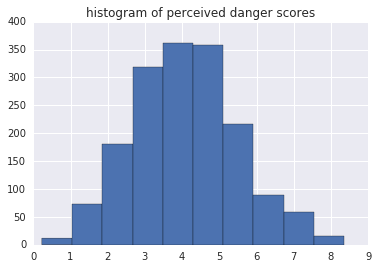

In [508]:
plt.hist(sso_ols.danger_score_raw)
plt.title('histogram of perceived danger scores');

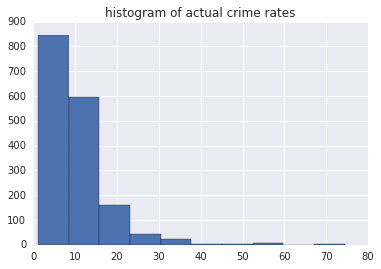

In [462]:
plt.hist(sso_ols.all_crimes_rate)
plt.title('histogram of actual crime rates');

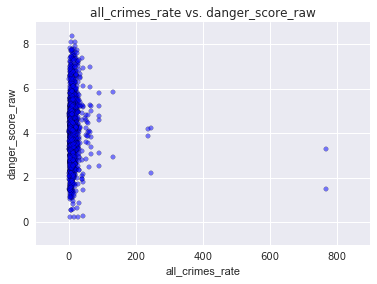

In [651]:
plot_scatter('all_crimes_rate', 'danger_score_raw', sso_ols)

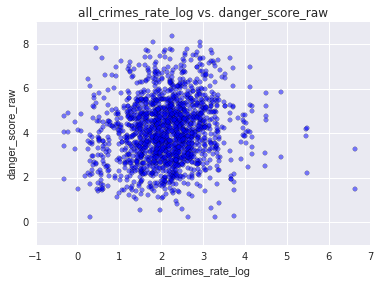

In [652]:
plot_scatter('all_crimes_rate_log', 'danger_score_raw', sso_ols)

In [58]:
crime_cols = ['burglary_rate', u'burglary_rate_log',
       u'felony_assault_rate', u'felony_assault_rate_log',
       u'grand_larceny_rate', u'grand_larceny_rate_log', u'murder_rate',
       u'murder_rate_log', u'rape_rate', u'rape_rate_log', u'robbery_rate',
       u'robbery_rate_log']

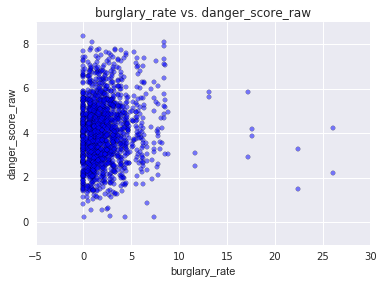

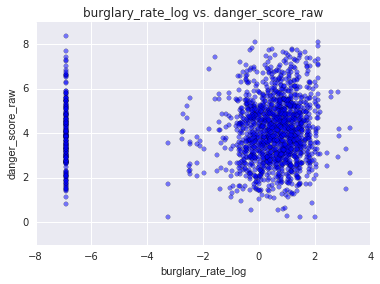

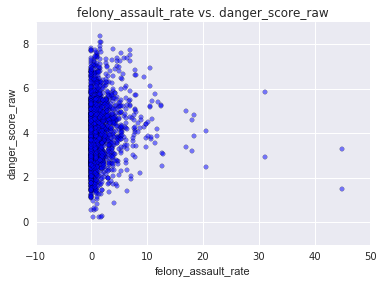

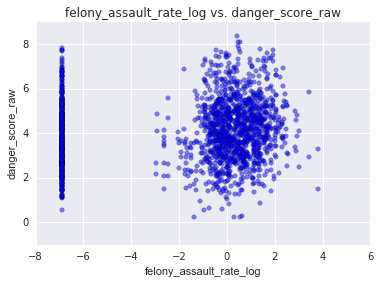

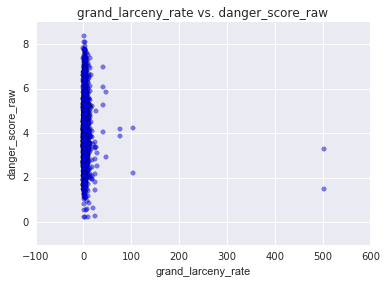

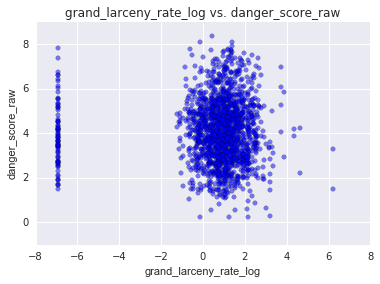

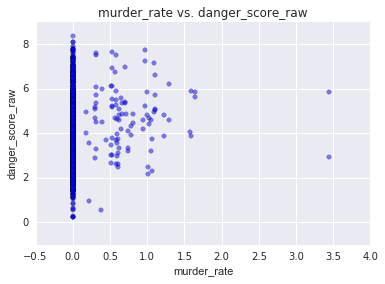

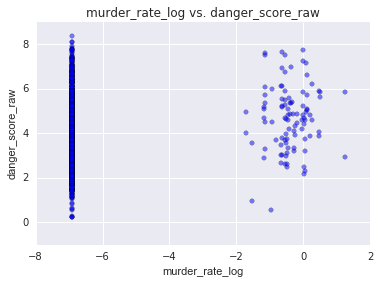

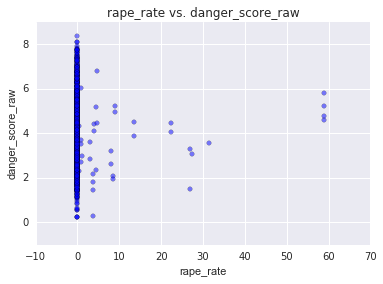

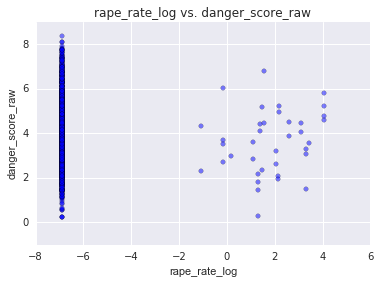

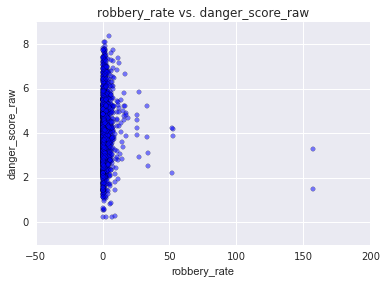

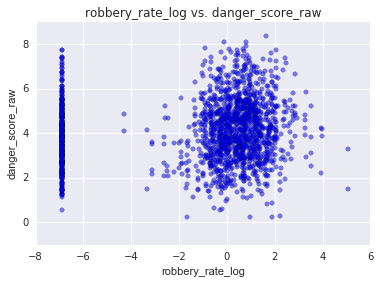

In [653]:
for c in crime_cols:
    plot_scatter(c, 'danger_score_raw', sso_ols)

Build linear regression models.

In [59]:
def get_dummies(df, cat_col):
    """Given df and categorical column, get dummies and reconcat."""
    cats = df[cat_col]
    cats = pd.get_dummies(cats, prefix = 'landuse')
    newdf = df.merge(cats, left_index = True, right_index = True)
    return newdf

In [60]:
def get_xy(features, ind, df):
    y = df[ind]
    X = df[features]
    X = sm.add_constant(X)
    return X, y

In [841]:
def sm_ols(features, ind, df):
    """Build linear regression model using statsmodels given df and columns names of features and variable to predict.
    """ 
    y = df[ind]
    X = df[features]
    X = sm.add_constant(X)
    return sm.OLS(y, X).fit()

In [62]:
def rgr_lasso(features, ind, df):
    y = df[ind]
    X = df[features]
    X = sm.add_constant(X)
    m = LassoCV(cv = 5)
    m.fit(X, y)
    return m

In [63]:
def rgr_ridge(features, ind, df):
    y = df[ind]
    X = df[features]
    X = sm.add_constant(X)
    m = RidgeCV(cv = 5)
    m.fit(X, y)
    return m

In [64]:
def sm_sig_features(model):
    """Return names of features with p value < 0.05 for statsmodels rgr model."""
    return [model.pvalues.index[i] for i, p in enumerate(model.pvalues) if p < 0.05]

**Crime only:** Try models with crime rate as the only predictor.

In [65]:
ssp_model_crime_only = sm_ols(['all_crimes_rate_log'], ['danger_score_raw'], ssp_ols)
sso_model_crime_only = sm_ols(['all_crimes_rate_log'], ['danger_score_raw'], sso_ols)

In [66]:
ssp_model_crime_only.rsquared

0.00050515908099801887

In [67]:
sso_model_crime_only.rsquared

0.014683189828492815

**Crime only by type of crime:** Try models with detailed crime rates.

In [68]:
crime_types = ['burglary_rate', 'felony_assault_rate', 'grand_larceny_rate', 'murder_rate', 'rape_rate', 'robbery_rate']
crime_types_log = [c + '_log' for c in crime_types]

In [69]:
# refined features
sso_crime_types = ['felony_assault_rate_log', 'murder_rate_log', 'robbery_rate_log', 'grand_larceny_rate', 'burglary_rate', 'rape_rate_log']

In [70]:
ssp_model_crime_types = sm_ols(crime_types, ['danger_score_raw'], ssp_ols)
sso_model_crime_types = sm_ols(sso_crime_types, ['danger_score_raw'], sso_ols)

In [71]:
# with refined features
sso_model_crime_types.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       danger_score_raw   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     10.84
Date:                Tue, 22 Mar 2016   Prob (F-statistic):           7.23e-12
Time:                        13:22:06   Log-Likelihood:                -2929.9
No. Observations:                1679   AIC:                             5874.
Df Residuals:                    1672   BIC:                             5912.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                       4.2547      0.247     17.252      0.000         3.771     4.738
felony_assault_rate_log     0.0334      0.011      2.977      0.003         0.011     0.055
murder_rate_log             0.0688      0.023      3.055      0.002         0.025     0.113
robbery_rate_log            0.0390      0.012      3.340      0.001         0.016     0.062
grand_larceny_rate         -0.0064      0.002     -2.898      0.004        -0.011    -0.002
burglary_rate               0.0367      0.017      2.139      0.033         0.003     0.070
rape_rate_log              -0.0464      0.028     -1.673      0.095        -0.101     0.008
==============================================================================
Omnibus:                       13.953   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.175
Skew:                           0.217   Prob(JB):                     0.000836
Kurtosis:                       2.882   Cond. No.                         139.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Other features model:** As evidenced by the low r-squared scores, actual crime rates do little to predict the perceived safety scores. Next, let's try adding features that might do more to explain why streetscapes are ranked as "unsafe." These features include:
* resident population density (to get at zoning code)  
* worker population density
* number of construction permits 
* housing types
* median income 
* housing values?

Socioeconomic indicators may be correlated with crime rates > what would explain PERCEPTION?

In [72]:
# load other socioeconomic data
edu = pd.read_csv('data/dem_data/acs_edu_attainment_25andolder_2014.csv') # done
home_value = pd.read_csv('data/dem_data/acs_med_home_value_2014.csv') # done
home_age = pd.read_csv('data/dem_data/acs_med_yr_house_built_2014.csv') # done
vacant_units = pd.read_csv('data/dem_data/acs_occupied_vacant_units_2010.csv') # done
home_type = pd.read_csv('data/dem_data/acs_housing_type_2014.csv')
income = pd.read_csv('data/dem_data/acs_med_hh_income_2014.csv') # done

In [364]:
def clean_median_data(data):
    """Clean high and low bounds of median data. Convert string to float."""
    try:
        if data[-1] == '-' or data[-1] == '+':
            try: 
                return float(data[:-1])
            except:
                return 0
        else:
            return float(data)
    except:
        return float(data)

In [754]:
def clean_acs(df, data_col, geo_name, data_name):
    """Clean acs data files with single column of data."""
    keep = ['GEO.id2', data_col]
    newdf = df[keep]
    newdf.rename(columns = {'GEO.id2': geo_name, data_col: data_name}, inplace = True)
    newdf.drop(0, inplace = True)
    newdf[data_name] = newdf.loc[:, data_name].apply(lambda x: clean_median_data(x))
    return newdf

In [75]:
def clean_acs_edu(df):
    """Calculate high school diploma attainment rates by geography."""
    keep = ['GEO.id2'] + [col for col in df.columns if 'HD01' in col]
    newdf = df[keep]
    metadata = newdf.loc[0, :]
    newdf.drop(0, inplace = True)
    newdf['hs_or_greater'] = newdf.loc[:, 'HD01_VD17':].astype(float).sum(axis = 1)
    newdf['pct_hs_or_greater'] = newdf.loc[:, 'hs_or_greater'] / newdf.loc[:, 'HD01_VD01'].astype(float)
    pctdf = newdf[['GEO.id2', 'pct_hs_or_greater']]
    pctdf.rename(columns = {'GEO.id2': 'block_group'}, inplace = True)
    return pctdf

In [76]:
def clean_acs_vacant_units(df):
    """Return percent vacant and occupied of total units by geography."""
    newdf = df.drop(['GEO.id', 'GEO.display-label'], axis = 1)
    newdf.drop(0, inplace = True)
    newdf['pct_occupied_units'] = newdf.loc[:, 'D002'].astype(float) / newdf.loc[:, 'D001'].astype(float)
    newdf['pct_vacant_units'] = newdf.loc[:, 'D003'].astype(float) / newdf.loc[:, 'D001'].astype(float)
    newdf.rename(columns = {'GEO.id2': 'block_group'}, inplace = True)
    return newdf[['block_group', 'pct_occupied_units', 'pct_vacant_units']]

In [77]:
def clean_acs_home_type(df):
    keep = ['GEO.id2'] + [col for col in df.columns if 'HD01' in col]
    newdf = df[keep]
    metadata = newdf.loc[0, :]
    newdf.drop(0, inplace = True)
    newdf['10_or_more_units'] = newdf.loc[:, 'HD01_VD07':'HD01_VD09'].astype(float).sum(axis = 1)
    newdf['pct_10_or_more_units'] = newdf.loc[:, '10_or_more_units'] / newdf.loc[:, 'HD01_VD01'].astype(float)
    pctdf = newdf[['GEO.id2', 'pct_10_or_more_units']]
    pctdf.rename(columns = {'GEO.id2': 'block_group'}, inplace = True)
    return pctdf

In [293]:
def multi_merge(df, merge_list, left_key = 'fips_big', right_key = 'block_group'):
    for mdf in merge_list:
        df = df.merge(mdf, how = 'left', left_on = left_key, right_on = right_key)
    try:
        newdf = df.drop(['block_group_x', 'block_group_y'], axis = 1)
    except:
        newdf = df
    return newdf

### PLUTO FILES  
Land use codes:  
* 1-4 = residential  
* 5 = commercial & office  
* 6-7 = industrial & manufacturing/transportation & utility  
* 8 = public facilities and institutions  
* 9 = open space  
* 10 = parking  
* 11 = vacant 

In [79]:
def concat_pluto(df_paths):
    """Given pluto files, concat into one df."""
    df = pd.concat([pd.read_csv(path) for path in df_paths])
    return df

In [80]:
def make_fips(ct2010, cb2010, borough):
    state = '36'
    boro_dict = {'BX': '005', 'BK': '047', 'MN': '061', 'QN': '081', 'SI': '085' }
    try:
        ct2010 = str(int(ct2010))
        if len(ct2010) == 4:
            ct = ct2010 + '00'
        elif len(ct2010) == 3:
            ct = '0' + ct2010 + '00'
        elif len(ct2010) == 2:
            ct = '00' + ct2010 + '00'
        elif len(ct2010) == 1:
            ct = '000' + ct2010 + '00'
        else: 
            ct = ct2010
        try:
            return state + boro_dict[borough] + ct + str(int(cb2010))
        except:
            return state + boro_dict[borough] + ct
    except:
        return np.nan

In [668]:
def clean_pluto(df):
    """Given raw pluto df, add clean block groups and census tracts."""
    
    # get census tract and block numbers
    df.loc[:,'clean_block'] = df.apply(lambda row: make_fips(row.CT2010, row.CB2010, row.Borough), axis = 1)
    newdf = df.dropna(subset = ['clean_block'])
    newdf.loc[:,'block_group'] = newdf.loc[:, 'clean_block'].apply(lambda x: x[:12] if len(x) == 15 else np.nan)
    newdf.loc[:,'fips_tract'] = newdf.loc[:, 'clean_block'].apply(lambda x: x[:11])
    return newdf

In [674]:
def agg_pluto_by_geo(df, geo):
    """Given pluto df with fips codes, get primary landuse by geography."""
    # get predominant land use code by block group
    newdf = df.dropna(subset = [geo])
    mode = lambda x: x.mode() if len(x) > 2 else np.array(x)
    grouped = newdf.groupby(geo)['LandUse'].agg(lambda x: x.value_counts().index[0])
    grouped = pd.DataFrame(grouped)
    grouped[geo] = grouped.index
    grouped.loc[:, 'LandUse'] = grouped.loc[:, 'LandUse'].apply(lambda x: pluto_dict[x])
    return grouped

In [84]:
pluto14 = concat_pluto(['data/pluto/pluto_2014/BK.csv', 'data/pluto/pluto_2014/BX.csv', 
                      'data/pluto/pluto_2014/MN.csv', 'data/pluto/pluto_2014/QN.csv', 'data/pluto/pluto_2014/SI.csv'])

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (15,16,18,19,21,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (15,16,18,19,62,63,78) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (16,19,20,21,78) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (15,16,18,19,62,63,75,78) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: D

In [85]:
pluto_dict = {1: 'res_single_fam', 2: 'res_multi_fam_walkup', 3: 'res_multi_fam_elevator', 
              4: 'mixed_res_commercial', 5: 'office', 6: 'ind_manu', 7: 'transport_utility', 
              8: 'public_inst', 9: 'open_space', 10: 'parking', 11: 'vacant'}

In [669]:
pluto_clean = clean_pluto(pluto14)

In [679]:
landuse_tract = agg_pluto_by_geo(pluto_clean, 'fips_tract')
landuse = agg_pluto_by_geo(pluto_clean, 'block_group')

### /PLUTO FILES

In [753]:
clean_acs??

In [88]:
# prep acs data
home_value_clean = clean_acs(home_value, 'HD01_VD01', 'block_group', 'med_home_value')
home_age_clean = clean_acs(home_age, 'HD01_VD01', 'block_group', 'med_yr_built')
income_clean = clean_acs(income, 'HD01_VD01', 'block_group', 'med_hh_income')
edu_clean = clean_acs_edu(edu)
vacant_units_clean = clean_acs_vacant_units(vacant_units)
home_type_clean = clean_acs_home_type(home_type)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main_

In [95]:
# merge with crime data
ssp_ols2 = multi_merge(ssp_ols, [home_value_clean, home_age_clean, income_clean, edu_clean, vacant_units_clean, home_type_clean, landuse])
ssp_ols2 = ssp_ols2.dropna()

sso_ols2 = multi_merge(sso_ols, [home_value_clean, home_age_clean, income_clean, edu_clean, vacant_units_clean, home_type_clean, landuse])
sso_ols2 = sso_ols2.dropna()

In [96]:
# get dummies for categorical variables
ssp_ols2 = get_dummies(ssp_ols2, 'LandUse')
sso_ols2 = get_dummies(sso_ols2, 'LandUse')

Run regression models to predict safety scores by image.

In [97]:
land_use_features = [col for col in ssp_ols2 if 'landuse' in col]
land_use_features.remove('landuse_res_single_fam')

In [98]:
ssp_ols_mega_features = ['all_crimes_rate_log', 'resident_density_log', 'worker_density_log', 
                         'med_yr_built', 'pct_hs_or_greater', 'pct_vacant_units', 'pct_10_or_more_units'] + land_use_features
ssp_mega_model = sm_ols(ssp_ols_mega_features, ['danger_score_raw'], ssp_ols2)

In [99]:
ssp_mega_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       danger_score_raw   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1283.
Date:                Tue, 22 Mar 2016   Prob (F-statistic):               0.00
Time:                        13:24:58   Log-Likelihood:            -7.1529e+05
No. Observations:              240127   AIC:                         1.431e+06
Df Residuals:                  240109   BIC:                         1.431e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
const                             10.9731      0.170     64.371      0.000        10.639    11.307
all_crimes_rate_log                0.2547      0.013     19.395      0.000         0.229     0.280
resident_density_log              -0.9002      0.010    -90.214      0.000        -0.920    -0.881
worker_density_log                 0.2240      0.007     31.048      0.000         0.210     0.238
med_yr_built                       0.0005   7.37e-05      6.943      0.000         0.000     0.001
pct_hs_or_greater                 -2.2675      0.079    -28.631      0.000        -2.423    -2.112
pct_vacant_units                   1.5339      0.162      9.442      0.000         1.216     1.852
pct_10_or_more_units               0.2948      0.041      7.129      0.000         0.214     0.376
landuse_ind_manu                   3.2294      0.065     49.474      0.000         3.101     3.357
landuse_mixed_res_commercial       0.0581      0.057      1.013      0.311        -0.054     0.170
landuse_office                     0.1696      0.069      2.450      0.014         0.034     0.305
landuse_open_space                -2.6406      0.099    -26.607      0.000        -2.835    -2.446
landuse_parking                    1.9365      0.146     13.270      0.000         1.650     2.222
landuse_public_inst               -0.4789      0.106     -4.509      0.000        -0.687    -0.271
landuse_res_multi_fam_elevator     0.3596      0.069      5.209      0.000         0.224     0.495
landuse_res_multi_fam_walkup       0.0497      0.032      1.547      0.122        -0.013     0.113
landuse_transport_utility          2.9400      0.173     17.000      0.000         2.601     3.279
landuse_vacant                     2.3534      0.175     13.410      0.000         2.009     2.697
==============================================================================
Omnibus:                     2417.770   Durbin-Watson:                   1.351
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3726.062
Skew:                          -0.095   Prob(JB):                         0.00
Kurtosis:                       3.580   Cond. No.                     3.61e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [100]:
ssp_mega_model_ridge = rgr_ridge(ssp_ols_mega_features, ['danger_score_raw'], ssp_ols2)

In [101]:
zip(['const'] + ssp_ols_mega_features, ssp_mega_model_ridge.coef_[0])

[('const', 0.0),
 ('all_crimes_rate_log', 0.25493293040517528),
 ('resident_density_log', -0.90006738986251733),
 ('worker_density_log', 0.22440323745462709),
 ('med_yr_built', 0.00050855487464492998),
 ('pct_hs_or_greater', -2.2617985735165114),
 ('pct_vacant_units', 1.5195026275594787),
 ('pct_10_or_more_units', 0.2964543921680135),
 ('landuse_ind_manu', 3.2240785478748197),
 ('landuse_mixed_res_commercial', 0.055488812381266531),
 ('landuse_office', 0.16714511812867885),
 ('landuse_open_space', -2.633103375439759),
 ('landuse_parking', 1.9186093809824341),
 ('landuse_public_inst', -0.47931141122998999),
 ('landuse_res_multi_fam_elevator', 0.35667573844035866),
 ('landuse_res_multi_fam_walkup', 0.04846264828410312),
 ('landuse_transport_utility', 2.9014093743267599),
 ('landuse_vacant', 2.3212619096955112)]

#### OLD MODELS

Predicted dataset - with pluto data & crime rates only

In [1203]:
ssp_ols_features2 = ['all_crimes_rate_log'] + land_use_features

In [1186]:
ssp_model_land_use = sm_ols(ssp_ols_features2, ['danger_score_raw'], ssp_ols2)

In [1200]:
features_keep = sm_sig_features(ssp_model_land_use)

In [1187]:
ssp_model_land_use.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       danger_score_raw   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     581.7
Date:                Mon, 21 Mar 2016   Prob (F-statistic):               0.00
Time:                        14:19:02   Log-Likelihood:            -5.9480e+05
No. Observations:              198857   AIC:                         1.190e+06
Df Residuals:                  198845   BIC:                         1.190e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
const                             12.7096      0.032    398.335      0.000        12.647    12.772
all_crimes_rate_log                0.3997      0.015     27.145      0.000         0.371     0.429
landuse_ind_manu                   5.3863      0.076     71.182      0.000         5.238     5.535
landuse_mixed_res_commercial       0.0564      0.075      0.753      0.452        -0.090     0.203
landuse_office                     1.0799      0.084     12.792      0.000         0.914     1.245
landuse_open_space                -0.1094      0.127     -0.859      0.390        -0.359     0.140
landuse_parking                    2.7758      0.231     12.013      0.000         2.323     3.229
landuse_public_inst               -0.2340      0.168     -1.389      0.165        -0.564     0.096
landuse_res_multi_fam_elevator    -0.5408      0.097     -5.562      0.000        -0.731    -0.350
landuse_res_multi_fam_walkup      -0.3469      0.035     -9.863      0.000        -0.416    -0.278
landuse_transport_utility          4.0053      0.442      9.067      0.000         3.139     4.871
landuse_vacant                     2.5341      0.324      7.832      0.000         1.900     3.168
==============================================================================
Omnibus:                     1369.814   Durbin-Watson:                   1.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2111.650
Skew:                          -0.014   Prob(JB):                         0.00
Kurtosis:                       3.504   Cond. No.                         97.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Predicted dataset - with crime rates & dem data

In [886]:
ssp_ols_features = ['all_crimes_rate_log', 'resident_density_log', 'worker_density_log', 
                    'med_home_value', 'med_yr_built', 'med_hh_income',
                    'pct_hs_or_greater', 'pct_vacant_units', 'pct_10_or_more_units']
ssp_model = sm_ols(ssp_ols_features, ['danger_score_raw'], ssp_ols2)

In [887]:
ssp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       danger_score_raw   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     2202.
Date:                Sun, 20 Mar 2016   Prob (F-statistic):               0.00
Time:                        15:15:29   Log-Likelihood:            -7.4956e+05
No. Observations:              253184   AIC:                         1.499e+06
Df Residuals:                  253174   BIC:                         1.499e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                  -39.9127      1.233    -32.361      0.000       -42.330   -37.495
all_crimes_rate_log      0.1674      0.013     13.073      0.000         0.142     0.193
resident_density_log    -0.9220      0.010    -89.769      0.000        -0.942    -0.902
worker_density_log       0.4141      0.007     59.478      0.000         0.400     0.428
med_home_value       -1.947e-06      6e-08    -32.436      0.000     -2.06e-06 -1.83e-06
med_yr_built             0.0277      0.001     43.388      0.000         0.026     0.029
med_hh_income        -6.574e-06   4.72e-07    -13.923      0.000      -7.5e-06 -5.65e-06
pct_hs_or_greater       -1.2304      0.101    -12.154      0.000        -1.429    -1.032
pct_vacant_units         3.2094      0.174     18.421      0.000         2.868     3.551
pct_10_or_more_units    -0.4275      0.038    -11.399      0.000        -0.501    -0.354
==============================================================================
Omnibus:                     2771.899   Durbin-Watson:                   1.333
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4363.331
Skew:                          -0.098   Prob(JB):                         0.00
Kurtosis:                       3.612   Cond. No.                     7.14e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.14e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Original dataset - all features

In [1208]:
land_use_features_sso = [col for col in sso_ols2 if 'landuse' in col]
land_use_features_sso.remove('landuse_res_single_fam')

In [1209]:
sso_ols_mega_features = ['all_crimes_rate_log', 'resident_density', 'worker_density', 
                    'med_home_value', 'med_yr_built', 'med_hh_income',
                    'pct_hs_or_greater', 'pct_vacant_units', 'pct_10_or_more_units'] + land_use_features_sso
sso_mega_model = sm_ols(sso_ols_mega_features, ['danger_score_raw'], sso_ols2)

In [1210]:
sso_mega_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       danger_score_raw   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     11.61
Date:                Mon, 21 Mar 2016   Prob (F-statistic):           2.22e-31
Time:                        14:34:05   Log-Likelihood:                -1937.1
No. Observations:                1169   AIC:                             3912.
Df Residuals:                    1150   BIC:                             4008.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
const                            -13.2958      5.429     -2.449      0.014       -23.948    -2.644
all_crimes_rate_log                0.1014      0.055      1.859      0.063        -0.006     0.208
resident_density                 -19.8330      4.398     -4.509      0.000       -28.463   -11.203
worker_density                    -4.4861      1.745     -2.571      0.010        -7.910    -1.063
med_home_value                 -9.615e-07   2.39e-07     -4.024      0.000     -1.43e-06 -4.93e-07
med_yr_built                       0.0100      0.003      3.609      0.000         0.005     0.015
med_hh_income                  -5.234e-06   1.91e-06     -2.736      0.006     -8.99e-06 -1.48e-06
pct_hs_or_greater                 -1.3946      0.371     -3.763      0.000        -2.122    -0.667
pct_vacant_units                   1.2850      0.599      2.147      0.032         0.111     2.460
pct_10_or_more_units              -0.2119      0.177     -1.196      0.232        -0.559     0.136
landuse_ind_manu                   0.6386      0.265      2.414      0.016         0.120     1.158
landuse_mixed_res_commercial      -0.1288      0.220     -0.586      0.558        -0.560     0.302
landuse_office                     0.2616      0.345      0.758      0.449        -0.416     0.939
landuse_open_space                 0.9149      0.927      0.987      0.324        -0.903     2.733
landuse_parking                    2.0520      0.918      2.235      0.026         0.251     3.853
landuse_public_inst               -0.2549      0.750     -0.340      0.734        -1.727     1.217
landuse_res_multi_fam_elevator     0.4115      0.302      1.362      0.173        -0.181     1.004
landuse_res_multi_fam_walkup       0.0634      0.107      0.592      0.554        -0.147     0.273
landuse_vacant                     0.9361      0.648      1.445      0.149        -0.335     2.208
==============================================================================
Omnibus:                       13.903   Durbin-Watson:                   1.635
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.222
Skew:                           0.270   Prob(JB):                     0.000816
Kurtosis:                       2.984   Cond. No.                     8.98e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.98e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1231]:
sso_mega_model_ridge = rgr_ridge(sso_ols_mega_features, ['danger_score_raw'], sso_ols2)

In [1233]:
zip(['const'] + sso_ols_mega_features, sso_mega_model_ridge.coef_[0])

[('const', 0.0),
 ('all_crimes_rate_log', 0.12341295151498735),
 ('resident_density', -9.0597076529503173),
 ('worker_density', -3.3947357832346552),
 ('med_home_value', -9.2452300649072242e-07),
 ('med_yr_built', 0.011579210472614848),
 ('med_hh_income', -5.445549663400805e-06),
 ('pct_hs_or_greater', -1.1533978641896696),
 ('pct_vacant_units', 1.3832801811770727),
 ('pct_10_or_more_units', -0.40232927216761322),
 ('landuse_ind_manu', 0.78448755118621638),
 ('landuse_mixed_res_commercial', -0.19083961778888087),
 ('landuse_office', 0.16745707919886749),
 ('landuse_open_space', 1.1152977262540802),
 ('landuse_parking', 2.1074982118275876),
 ('landuse_public_inst', -0.41332849172974018),
 ('landuse_res_multi_fam_elevator', 0.35808492357817312),
 ('landuse_res_multi_fam_walkup', -0.008426296632900029),
 ('landuse_vacant', 0.98986313602824616)]

In [1213]:
sso_keep_features = [feat for feat in sm_sig_features(sso_mega_model) if 'const' not in feat]
print sso_keep_features

['resident_density', 'worker_density', 'med_home_value', 'med_yr_built', 'med_hh_income', 'pct_hs_or_greater', 'pct_vacant_units', 'landuse_ind_manu', 'landuse_parking']


In [1214]:
sso_mega_model2 = sm_ols(sso_keep_features, ['danger_score_raw'], sso_ols2)

In [1215]:
sso_mega_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       danger_score_raw   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     21.94
Date:                Mon, 21 Mar 2016   Prob (F-statistic):           1.29e-34
Time:                        14:36:33   Log-Likelihood:                -1942.7
No. Observations:                1169   AIC:                             3905.
Df Residuals:                    1159   BIC:                             3956.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const               -11.1596      5.142     -2.170      0.030       -21.249    -1.071
resident_density    -23.0069      3.460     -6.649      0.000       -29.796   -16.218
worker_density       -4.5140      1.057     -4.269      0.000        -6.589    -2.439
med_home_value    -1.004e-06   2.31e-07     -4.345      0.000     -1.46e-06 -5.51e-07
med_yr_built          0.0091      0.003      3.456      0.001         0.004     0.014
med_hh_income     -5.154e-06   1.83e-06     -2.817      0.005     -8.74e-06 -1.56e-06
pct_hs_or_greater    -1.5578      0.346     -4.503      0.000        -2.237    -0.879
pct_vacant_units      1.3328      0.587      2.269      0.023         0.180     2.485
landuse_ind_manu      0.5383      0.252      2.137      0.033         0.044     1.032
landuse_parking       1.8728      0.914      2.049      0.041         0.080     3.666
==============================================================================
Omnibus:                       13.198   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.506
Skew:                           0.263   Prob(JB):                      0.00117
Kurtosis:                       2.963   Cond. No.                     8.19e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.19e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1234]:
sso_mega_model2_ridge = rgr_ridge(sso_keep_features, ['danger_score_raw'], sso_ols2)

In [1235]:
zip(['const'] + sso_keep_features, sso_mega_model2_ridge.coef_[0])

[('const', 0.0),
 ('resident_density', -13.334409933848619),
 ('worker_density', -4.3470417510811892),
 ('med_home_value', -9.901506417304332e-07),
 ('med_yr_built', 0.0099744076324924727),
 ('med_hh_income', -5.2410219894826287e-06),
 ('pct_hs_or_greater', -1.4179061802241568),
 ('pct_vacant_units', 1.4214056034440183),
 ('landuse_ind_manu', 0.65928194684787289),
 ('landuse_parking', 1.8676238581952556)]

#### OLD MODELS 

Original dataset - with pluto data & crime rates only

In [1141]:
sso_ols_features2 = ['all_crimes_rate_log', 'LandUse']

In [1142]:
X2, y2 = get_xy(sso_ols_features2, ['danger_score_raw'], sso_ols2)

In [1144]:
X2.drop('LandUse_res_single_fam', axis = 1, inplace = True)

In [1146]:
model = sm.OLS(y2, X2).fit()

In [1147]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       danger_score_raw   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     8.138
Date:                Mon, 21 Mar 2016   Prob (F-statistic):           8.18e-13
Time:                        14:03:20   Log-Likelihood:                -1994.9
No. Observations:                1169   AIC:                             4012.
Df Residuals:                    1158   BIC:                             4068.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
const                              3.6236      0.123     29.531      0.000         3.383     3.864
all_crimes_rate_log                0.2643      0.054      4.879      0.000         0.158     0.371
LandUse_ind_manu                   0.8331      0.249      3.340      0.001         0.344     1.322
LandUse_mixed_res_commercial      -0.7347      0.195     -3.763      0.000        -1.118    -0.352
LandUse_office                    -0.7859      0.199     -3.940      0.000        -1.177    -0.395
LandUse_open_space                 0.3057      0.950      0.322      0.748        -1.558     2.169
LandUse_parking                    2.5977      0.949      2.739      0.006         0.737     4.459
LandUse_public_inst               -1.0295      0.775     -1.328      0.184        -2.550     0.491
LandUse_res_multi_fam_elevator    -0.2182      0.284     -0.768      0.442        -0.775     0.339
LandUse_res_multi_fam_walkup      -0.1346      0.101     -1.339      0.181        -0.332     0.063
LandUse_vacant                     0.7631      0.672      1.135      0.256        -0.555     2.082
==============================================================================
Omnibus:                       13.265   Durbin-Watson:                   1.550
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.566
Skew:                           0.263   Prob(JB):                      0.00113
Kurtosis:                       2.971   Cond. No.                         59.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Original dataset - with crime rates & dem data

In [888]:
sso_ols_features = ['all_crimes_rate_log', 'resident_density', 'worker_density', 
                    'med_home_value', 'med_yr_built', 'med_hh_income',
                    'pct_hs_or_greater', 'pct_vacant_units', 'pct_10_or_more_units']
sso_model = sm_ols(sso_ols_features, ['danger_score_raw'], sso_ols2)

In [912]:
sso_ols_features_crime_types = sso_ols_features[1:] + sso_crime_types 

In [913]:
sso_model_crime_types_with_dem = sm_ols(sso_ols_features_crime_types, ['danger_score_raw'], sso_ols2)

In [914]:
sso_model_crime_types_with_dem.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       danger_score_raw   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     17.32
Date:                Sun, 20 Mar 2016   Prob (F-statistic):           2.62e-37
Time:                        16:32:35   Log-Likelihood:                -2158.8
No. Observations:                1302   AIC:                             4346.
Df Residuals:                    1288   BIC:                             4418.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                     -12.2614      5.111     -2.399      0.017       -22.288    -2.235
resident_density          -23.0297      3.734     -6.167      0.000       -30.356   -15.703
worker_density             -4.5879      1.111     -4.131      0.000        -6.767    -2.409
med_home_value          -9.491e-07   2.18e-07     -4.348      0.000     -1.38e-06 -5.21e-07
med_yr_built                0.0098      0.003      3.760      0.000         0.005     0.015
med_hh_income           -4.194e-06   1.79e-06     -2.342      0.019     -7.71e-06  -6.8e-07
pct_hs_or_greater          -1.2749      0.352     -3.626      0.000        -1.965    -0.585
pct_vacant_units            1.3467      0.568      2.369      0.018         0.231     2.462
pct_10_or_more_units        0.0435      0.147      0.296      0.767        -0.245     0.332
felony_assault_rate_log     0.0245      0.012      2.069      0.039         0.001     0.048
murder_rate_log             0.0756      0.025      3.080      0.002         0.027     0.124
robbery_rate_log            0.0199      0.012      1.625      0.104        -0.004     0.044
grand_larceny_rate         -0.0207      0.008     -2.640      0.008        -0.036    -0.005
burglary_rate               0.0118      0.021      0.567      0.571        -0.029     0.053
==============================================================================
Omnibus:                       12.344   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.512
Skew:                           0.240   Prob(JB):                      0.00192
Kurtosis:                       3.015   Cond. No.                     8.76e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.76e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [889]:
# with additional demographic features
sso_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       danger_score_raw   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     22.17
Date:                Sun, 20 Mar 2016   Prob (F-statistic):           2.72e-35
Time:                        15:16:12   Log-Likelihood:                -2170.2
No. Observations:                1302   AIC:                             4360.
Df Residuals:                    1292   BIC:                             4412.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                  -13.5051      5.109     -2.643      0.008       -23.528    -3.482
all_crimes_rate_log      0.0734      0.050      1.480      0.139        -0.024     0.171
resident_density       -20.6696      3.727     -5.545      0.000       -27.982   -13.357
worker_density          -4.3229      1.127     -3.835      0.000        -6.534    -2.112
med_home_value        -1.06e-06   2.19e-07     -4.849      0.000     -1.49e-06 -6.31e-07
med_yr_built             0.0102      0.003      3.896      0.000         0.005     0.015
med_hh_income        -4.854e-06   1.78e-06     -2.721      0.007     -8.35e-06 -1.35e-06
pct_hs_or_greater       -1.4655      0.349     -4.195      0.000        -2.151    -0.780
pct_vacant_units         1.4730      0.569      2.589      0.010         0.357     2.589
pct_10_or_more_units    -0.0269      0.143     -0.188      0.851        -0.308     0.254
==============================================================================
Omnibus:                       11.148   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.307
Skew:                           0.228   Prob(JB):                      0.00351
Kurtosis:                       2.989   Cond. No.                     8.69e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.69e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [799]:
sso_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       danger_score_raw   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     28.80
Date:                Sun, 20 Mar 2016   Prob (F-statistic):           6.70e-33
Time:                        14:09:05   Log-Likelihood:                -2797.9
No. Observations:                1643   AIC:                             5610.
Df Residuals:                    1636   BIC:                             5648.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                    6.5462      0.536     12.222      0.000         5.496     7.597
all_crimes_rate_log      0.0561      0.045      1.249      0.212        -0.032     0.144
resident_density       -18.9847      2.666     -7.122      0.000       -24.213   -13.756
worker_density          -5.3463      0.906     -5.898      0.000        -7.124    -3.568
pct_hs_or_greater       -2.1467      0.256     -8.383      0.000        -2.649    -1.644
pct_occupied_units      -0.5638      0.487     -1.157      0.247        -1.520     0.392
pct_10_or_more_units     0.2710      0.114      2.383      0.017         0.048     0.494
==============================================================================
Omnibus:                       14.215   Durbin-Watson:                   1.621
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.501
Skew:                           0.226   Prob(JB):                     0.000710
Kurtosis:                       2.910   Cond. No.                         223.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Try model with lasso regularization.

In [933]:
sso_model_crime_types_with_dem_lasso = rgr_lasso(sso_ols_features_crime_types, ['danger_score_raw'], sso_ols2)

//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [934]:
sso_model_crime_types_with_dem_lasso.alpha_

151.7075655046844

In [937]:
sso_model_crime_types_with_dem_lasso.coef_

array([  0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -9.39390760e-07,   0.00000000e+00,  -7.58096774e-06,
        -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00])

In [ ]:
sso_model_crime_types_with_dem_lasso.predict()

In [941]:
sso_model_crime_types_with_dem_ridge = rgr_ridge(sso_ols_features_crime_types, ['danger_score_raw'], sso_ols2)

### Compare predicted values for perceived danger score

In [268]:
def agg_pred_scores(df, geo):
    keep = [geo] + ['danger_score_raw', 'danger_score_norm', 'danger_pred', 'all_crimes_rate']
    newdf = df[keep]
    newdf.loc[:, 'resid'] = newdf.loc[:, 'danger_score_raw'] - newdf.loc[:, 'danger_pred']
    bygeo = newdf.groupby(geo)
    stds = bygeo.std()
    means = bygeo.mean()
    medians = bygeo.median()
    counts = bygeo.count()
    aggdf = pd.DataFrame({geo: stds.index, 
                         'danger_score_raw_mean': means.danger_score_raw,
                         'danger_score_raw_median': medians.danger_score_raw, 
                         'danger_score_raw_std': stds.danger_score_raw, 
                         'crime_rate_mean': means.all_crimes_rate,
                         'crime_rate_median': medians.all_crimes_rate,
                         'crime_rate_std': stds.all_crimes_rate,
#                          'danger_score_pred_mean': means.danger_pred,
#                          'danger_score_pred_median': medians.danger_pred,
#                          'danger_score_pred_std': stds.danger_pred,
#                          'resid_mean': means.resid, 
#                          'resid_median': medians.resid, 
#                          'resid_std': stds.resid, 
                         'num_images': counts.resid})
    return aggdf

In [269]:
def get_img_resids(df, features, model):
    X, y = get_xy(features, ['danger_score_raw'], df)
    pred = model.predict(X)
    df['danger_pred'] = pred

#### Compare predicted vs. actual values for model with crime data only -- ORIGINAL

In [104]:
get_img_resids(sso_ols, sso_crime_types, sso_model_crime_types)

In [105]:
sso_scores_crime_only = agg_pred_scores(sso_ols, 'fips_bg')

#### Compare predicted vs. actual values for crime data only -- PREDICTED SCORES

In [1439]:
tract_to_cartodb(ssp_scores_tract, 'data/for_cartodb/scores_by_tract.csv')

Model just predicts a baseline, so the residuals don't actually say anything; equivalent to just using the raw danger score. Let's try going back to computing a score without a model.

#### Compute difference score using number of standard deviations from the mean.

In [270]:
get_img_resids(ssp_ols, crime_types, ssp_model_crime_types)
ssp_scores_bg = agg_pred_scores(ssp_ols, 'fips_bg')
ssp_scores_tract = agg_pred_scores(ssp_ols, 'fips_tract')

In [215]:
def med_abs_dev(arr):
    return np.median(np.abs(arr - np.median(arr)))/.6745

In [231]:
def mad_from_median(s):
    """Calculate standardized distance from the median using median absolute deviance.
    Implemented bc of outliers in dataset."""
    median = s.median()
    mad = np.median(np.abs(s - median))
    scores = [(data - median) / mad for data in s]
    return scores

In [109]:
def std_from_mean(s):
    """Calculate z-scores for data points; i.e. standardized distance from the mean."""
    mean = s.mean()
    std = s.std()
    scores = [(data - mean) / std for data in s]
    return scores

In [271]:
# std from mean
ssp_scores_tract['crime_rate_std_from_mean'] = std_from_mean(ssp_scores_tract.crime_rate_mean)
ssp_scores_tract['danger_score_std_from_mean'] = std_from_mean(ssp_scores_tract.danger_score_raw_mean)

In [272]:
# median abs deviance from median
ssp_scores_tract['crime_rate_mad_from_med'] = mad_from_median(ssp_scores_tract.crime_rate_mean)
ssp_scores_tract['danger_score_mad_from_med'] = mad_from_median(ssp_scores_tract.danger_score_raw_mean)

In [273]:
# get difference in scores
ssp_scores_tract['diff_std_from_mean'] = ssp_scores_tract.loc[:, 'crime_rate_std_from_mean'] - ssp_scores_tract.loc[:, 'danger_score_std_from_mean']
ssp_scores_tract['diff_mad_from_med'] = ssp_scores_tract.loc[:, 'crime_rate_mad_from_med'] - ssp_scores_tract.loc[:, 'danger_score_mad_from_med']

In [1487]:
# tract_to_cartodb(ssp_scores_tract, 'data/for_cartodb/scores_by_tract2.csv')

### <a id='4'></a> 4. Cluster census tracts based on variance and difference scores.

#### Cluster by hand into three categories based on difference scores.
* within one standard deviation of the mean difference score
* over one standard deviation above mean difference
* over one standard deviation below mean difference

In [145]:
def cluster_manual(df, score_col, data):
    """Categorize difference scores based on standard deviations from the mean."""
    mean = df[score_col].mean()
    std = df[score_col].std()
    lower_bound = mean - std
    upper_bound = mean + std
    
    # diff = crime rate - perceived danger 
    if data > upper_bound:
        return 0 # actually more dangerous than perceived
    elif data <= upper_bound and data >= lower_bound:
        return 1 # within 1 std of mean
    else:
        return 2 # actually safer than perceived 

In [240]:
def cluster_manual_med(df, score_col, data):
    """Categorize difference scores based on median absolute deviation from median and sort into clusters."""
    median = np.median(df[score_col])
#     mad = med_abs_dev(df[score_col])
    mad = np.median(np.abs(df[score_col] - median))
    lower_bound = median - mad
    upper_bound = median + mad
    
    # diff = crime rate - perceived danger 
    if data > upper_bound:
        return 0 # actually more dangerous than perceived
    elif data <= upper_bound and data >= lower_bound:
        return 1 # within 1 std of mean
    else:
        return 2 # actually safer than perceived 

In [236]:
def add_manual_clusters(df, score_col):
    df['manual_cluster_score'] = df.loc[:, score_col].apply(lambda x: cluster_manual(df, score_col, x))

In [276]:
def add_manual_clusters_med(df, score_col):
    df['manual_cluster_score_med'] = df.loc[:, score_col].apply(lambda x: cluster_manual_med(df, score_col, x))

In [530]:
def add_diff_score_score(df, score_col):
    """Create score from difference score to measure variation. For use in rgr model."""
    df['diff_zscore'] = mad_from_median(df.loc[:, score_col])

In [277]:
add_manual_clusters(ssp_scores_tract, 'diff_std_from_mean')
add_manual_clusters_med(ssp_scores_tract, 'diff_mad_from_med')

In [531]:
# create score from difference score -- for use in rgr model
add_diff_score_score(ssp_scores_tract, 'diff_mad_from_med')

In [229]:
tract_to_cartodb(ssp_scores_tract, 'data/for_cartodb/scores_by_tract4.csv')

In [243]:
ssp_scores_tract.manual_cluster_med_orig.value_counts()

1    1056
0     535
2     520
Name: manual_cluster_med_orig, dtype: int64

In [239]:
ssp_scores_tract.manual_cluster_med.value_counts()

1    1434
0     350
2     327
Name: manual_cluster_med, dtype: int64

#### Cluster using kmeans clustering -- need to add additional variables.
Concept: neighborhood selection tool for someone looking to find a different NYC neighborhood based on attributes of one they currently live in/know well.

A user can put in his address & select on sliders from the following:
* safer than perceived <> more dangerous than perceived OR
    * more dangerous <> safer
* less variability in surrounding neighborhood <> more variability in surrounding neighborhood
* lower rent <> higher rent 
* others?

Implementation - LDA or NMF to get highest probability/similarity score. Word2vec?

In [116]:
ssp_scores_tract.dropna(inplace = True)

In [117]:
def kmeans_cluster(df, features, k = 5):
    km = KMeans(n_clusters = k)
    km.fit_predict(df[features])
    return km, km.fit_predict(df[features])

In [134]:
def get_cluster_info(model, model_features):
    """Return df of cluster centroids and number of items assigned to each cluster given a fitted cluster
    model and list of model features."""
    df = pd.DataFrame(data = model.cluster_centers_, columns = model_features)
    df['counts'] = [model.labels_.tolist().count(i) for i in df.index]
    return df

In [265]:
cluster_features =  ['manual_cluster_med', 'danger_score_raw_std']

In [266]:
clusttest, clustpred = kmeans_cluster(ssp_scores_tract, cluster_features, k = 3)

In [267]:
cluster_df = get_cluster_info(clusttest, cluster_features)
cluster_df.head()

manual_cluster_med  danger_score_raw_std  counts
0        1.140845e+00              3.851403    1136
1        1.227907e+00              5.201544     645
2       -1.665335e-15              4.629233     330

(0, 10)

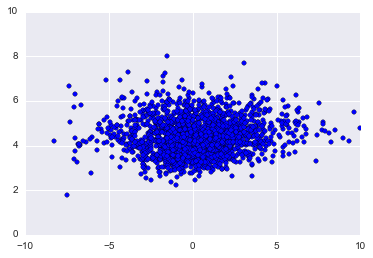

In [262]:
plt.scatter(ssp_scores_tract.diff_mad_from_med, ssp_scores_tract.danger_score_raw_std)
plt.xlim(-10, 10)
plt.ylim(0, 10)

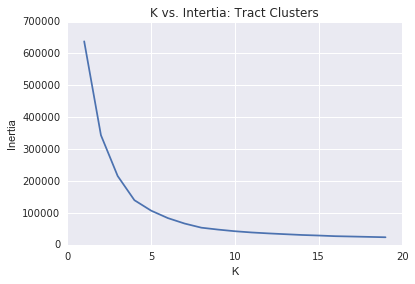

In [1516]:
# plot k vs. intertia
inertias = []
for k in range(1, 20):
    mod = kmeans_cluster(ssp_scores_tract, ['crime_rate_mean', 'crime_rate_std', 'danger_score_raw_mean', 
                            'danger_score_raw_std', 'diff_std_from_mean'], k = k)
    inertias.append(mod.inertia_)
    
plt.plot(range(1, 20), inertias)
plt.title('K vs. Intertia: Tract Clusters')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

###  <a id='5'></a> 5. Investigate any prominent impacts of difference scores.
Potential impacts:
* crime rates over time
* educational attainment
* home values

In [837]:
def clean_acs_income(df):
    """Clean acs income data by tract."""
    keep = ['GEO.id2', 'HC02_EST_VC02']
    newdf = df[keep]
    newdf.rename(columns = {'GEO.id2': 'tract', 'HC02_EST_VC02': 'median_hh_income'}, inplace = True)
    newdf.drop(0, inplace = True)
    newdf.replace('-', np.nan, inplace = True)
    newdf.replace('0', np.nan, inplace = True)
    newdf.loc[:, 'median_hh_income'] = newdf.loc[:, 'median_hh_income'].apply(clean_median_data)
    newdf['median_hh_income_log'] = np.log(newdf.median_hh_income)
    newdf.replace([np.inf, -np.inf], np.nan, inplace = True)
    newdf.dropna(inplace = True)
    return newdf

In [428]:
def clean_lai(df):
    keep = ['tract', 'hh_type1_ht_own', 'hh_type1_h_own', 'hh_type1_ht_rent', 'hh_type1_h_rent', 'hh_type1_ht', 'hh_type1_h']
    newdf = df[keep]
    newdf['tract'] = newdf.loc[:, 'tract'].apply(lambda x: x[1:-1])
    return newdf

In [518]:
def clean_impacts_df(df):
    keep = ['crime_rate_std', 'danger_score_raw_median', 'danger_score_raw_std', 'diff_mad_from_med', 
            'manual_cluster_med', 'diff_score']
    newdf = df[keep]
    newdf['tract'] = newdf.index
    return newdf

In [354]:
def single_merge(odf, mdf, leftkey, rightkey):
    df = odf.merge(mdf, how = 'left', left_on = leftkey, right_on = rightkey)
    return df

In [388]:
# import impacts data by tract geography
edu_bt = pd.read_csv('data/dem_data/acs_edu_attainment_25andolder_2014_bt.csv')
income_bt = pd.read_csv('data/dem_data/acs_med_hh_income_2014_bt.csv')
lai = pd.read_csv('data/lai_data_36_tracts.csv')

In [393]:
lai_bg = pd.read_csv('data/lai_data_36_blkgrps.csv')

In [476]:
edu_bt_clean = clean_acs_edu(edu_bt)
income_bt_clean = clean_acs_income(income_bt)
lai_clean = clean_lai(lai)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main_

#### SCORES FOR IMPACT START

scores_for_impact = clean_impacts_df(ssp_scores_tract)

In [520]:
scores_for_impact = single_merge(scores_for_impact, edu_bt_clean, leftkey = 'tract', rightkey = 'block_group')
scores_for_impact = single_merge(scores_for_impact, income_bt_clean, leftkey = 'tract', rightkey = 'tract')
scores_for_impact = single_merge(scores_for_impact, lai_clean, leftkey = 'tract', rightkey = 'tract')

In [318]:
scores_for_impact.groupby('manual_cluster_med')['pct_hs_or_greater'].median()

manual_cluster_med
0    0.800844
1    0.816991
2    0.851661
Name: pct_hs_or_greater, dtype: float64

#### Test impact of streetscore data by comparing models
* educational attainment: 0.471 vs. 0.471 - no impact
* neighborhood affordability (housing & trans costs as % of income): .309 vs. .312 (p = .002)
    * .309 vs .312 when using the manual clusters
* home values
* actual crime rates - correlation?

In [528]:
# define Xs and ys
dependent_var = ['hh_type1_ht']
impact_base_features = ['median_hh_income_log']
impact_features = impact_base_features + ['diff_score', 'danger_score_raw_std']
model_df = scores_for_impact.dropna().drop(2114)

In [502]:
impact_model_base = sm_ols(impact_base_features, dependent_var, model_df)
impact_model_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hh_type1_ht   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     2652.
Date:                Wed, 23 Mar 2016   Prob (F-statistic):               0.00
Time:                        13:54:15   Log-Likelihood:                -5731.5
No. Observations:                2085   AIC:                         1.147e+04
Df Residuals:                    2083   BIC:                         1.148e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                  -50.8743      1.842    -27.622      0.000       -54.486   -47.262
median_hh_income_log     8.7243      0.169     51.493      0.000         8.392     9.057
==============================================================================
Omnibus:                      134.101   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.372
Skew:                          -0.466   Prob(JB):                     8.62e-54
Kurtosis:                       4.394   Cond. No.                         244.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [529]:
impact_model = sm_ols(impact_features, dependent_var, model_df)
impact_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hh_type1_ht   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     917.2
Date:                Wed, 23 Mar 2016   Prob (F-statistic):               0.00
Time:                        14:13:44   Log-Likelihood:                -5709.1
No. Observations:                2085   AIC:                         1.143e+04
Df Residuals:                    2081   BIC:                         1.145e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                  -51.1944      1.919    -26.684      0.000       -54.957   -47.432
median_hh_income_log     8.9142      0.171     52.042      0.000         8.578     9.250
diff_score               0.2317      0.040      5.724      0.000         0.152     0.311
danger_score_raw_std    -0.4044      0.104     -3.893      0.000        -0.608    -0.201
==============================================================================
Omnibus:                      124.889   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.236
Skew:                          -0.508   Prob(JB):                     1.63e-40
Kurtosis:                       4.037   Cond. No.                         276.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 6. REVERSE REVERSE - Build model to predict difference scores
Features to include:

PHYSICAL
* primary land use OR % residential, industrial, etc. 
* median year buildings were built 
* building heights? -- additional features to account for physical apperance not covered in age and building type
* percent of housing units vacant
* percent of housing units with 10 or more units 
* vacancy rates overall
* home values
* median rent 

DEMOGRAPHIC
* household income
* education levels
* household types - single family, individual, etc.
* affordability
* age
* race
* resident/worker population density 

FEATURE ENGINEERING TO DOS: 
* young males 

#### Clean/prep features

In [798]:
def get_pop_density(df):
    """Get resident and worker density from crime df."""
    keep = ['population', 'workers', 'total_pop', 'tract_area']
    newdf = df[keep]
    newdf.rename(columns = {'population': 'residents'}, inplace = True)
    
    # add population density
    newdf['resident_density'] = newdf.loc[:, 'residents'] / newdf.loc[:, 'tract_area']
    newdf['worker_density'] = newdf.loc[:, 'workers'] / newdf.loc[:, 'tract_area']
    
    # add log of population density
    log_transform('resident_density', newdf)
    log_transform('worker_density', newdf)
    
    # add tract column
    newdf['tract'] = newdf.index
    
    return newdf

In [727]:
def pluto_med_age(df, geo):
    """Get median building age by geography from pluto data."""
    newdf = df[df.YearBuilt != 0]
    newdf.dropna(subset = [geo], inplace = True)
    grouped = newdf.groupby(geo)['YearBuilt'].agg(lambda x: np.median(x))
    grouped = pd.DataFrame(grouped)
    grouped['tract'] = grouped.index
    return grouped

In [745]:
def clean_acs_gender(df):
    keep = ['GEO.id2', 'HC01_EST_VC01', 'HC02_EST_VC01']
    newdf = df[keep]
    newdf.drop(0, inplace = True)
    newdf.loc[:,'pct_male'] = newdf.loc[:, 'HC02_EST_VC01'].astype(float) / newdf.loc[:, 'HC01_EST_VC01'].astype(float)
    newdf.rename(columns = {'GEO.id2': 'tract'}, inplace = True)
    return newdf[['tract', 'pct_male']]

In [781]:
def clean_acs_race(df):
    keep = ['GEO.id2', 'D002', 'D003']
    newdf = df[keep]
    newdf.drop(0, inplace = True)
    newdf['race_pct_nonwhite'] = 1 - (newdf.loc[:, 'D003'].astype(float) / newdf.loc[:, 'D002'].astype(float))
    newdf.rename(columns = {'GEO.id2': 'tract'}, inplace = True)
    return newdf[['tract', 'race_pct_nonwhite']]

In [728]:
# median bldg age
bldg_age = pluto_med_age(pluto_clean, 'fips_tract')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [738]:
# age and gender
age = pd.read_csv('data/dem_data/acs_med_age_by_sex_2014.csv')
gender = pd.read_csv('data/dem_data/acs_sex_by_tract_2014.csv')
race = pd.read_csv('data/dem_data/census_race_by_tract_2010.csv')

In [746]:
gender_clean = clean_acs_gender(gender)
age_clean = clean_acs(age, 'HD01_VD02', 'tract', 'median_age')
age_clean = clean_acs(age, 'HD01_VD02', 'tract', 'median_age')
race_clean = clean_acs_race(race)
density = get_pop_density(crime2014_ct)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

In [800]:
density.head()

Offense      residents  workers  total_pop      tract_area  resident_density  \
fips_tract                                                                     
36005000200       5095       51       5146   5050182.71191          0.001009   
36005000400       5572      310       5882   8551573.02668          0.000652   
36005001600       5412      578       5990   5221332.29582          0.001037   
36005001900       2569     5666       8235  17964480.95910          0.000143   
36005002000       8959      132       9091   4270706.70640          0.002098   

Offense      worker_density  resident_density_log  worker_density_log  \
fips_tract                                                              
36005000200        0.000010             -6.898920          -11.503109   
36005000400        0.000036             -7.336116          -10.225054   
36005001600        0.000111             -6.871889           -9.108689   
36005001900        0.000315             -8.852635           -8.061668   
36005002000        0.000031             -6.166876          -10.384488   

Offense            tract  
fips_tract                
36005000200  36005000200  
36005000400  36005000400  
36005001600  36005001600  
36005001900  36005001900  
36005002000  36005002000

#### prep stuff

In [655]:
scores_for_impact = single_merge(scores_for_impact, landuse_tract, 'tract', 'tract')

In [731]:
scores_for_impact = single_merge(scores_for_impact, bldg_age, 'tract', 'tract')

In [749]:
scores_for_impact = single_merge(scores_for_impact, gender_clean, 'tract', 'tract')

In [758]:
scores_for_impact = single_merge(scores_for_impact, age_clean, 'tract', 'tract')

In [783]:
scores_for_impact = single_merge(scores_for_impact, race_clean, 'tract', 'tract')

In [801]:
scores_for_impact = single_merge(scores_for_impact, density, 'tract', 'tract')

In [657]:
scores_for_impact = get_dummies(scores_for_impact, 'LandUse')

In [659]:
land_use_features_tract = [col for col in scores_for_impact if 'landuse' in col]
land_use_features_tract.remove('landuse_res_single_fam')

In [816]:
model_features = ['median_hh_income_log', 'hh_type1_ht', 'pct_hs_or_greater', 
                  'pct_male', 'YearBuilt', 'median_age'] + land_use_features_tract

In [820]:
scores_for_impact.shape

(2137, 41)

In [848]:
model_df = scores_for_impact[model_features + ['diff_score']].dropna()
model = sm_ols(model_features, ['diff_score'], model_df)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             diff_score   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 24 Mar 2016   Prob (F-statistic):                nan
Time:                        10:56:18   Log-Likelihood:                    nan
No. Observations:                1712   AIC:                               nan
Df Residuals:                    1712   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
const                                 nan        nan        nan        nan           nan       nan
median_hh_income_log                  nan        nan        nan        nan           nan       nan
hh_type1_ht                           nan        nan        nan        nan           nan       nan
pct_hs_or_greater                     nan        nan        nan        nan           nan       nan
pct_male                              nan        nan        nan        nan           nan       nan
YearBuilt                             nan        nan        nan        nan           nan       nan
median_age                            nan        nan        nan        nan           nan       nan
landuse_ind_manu                      nan        nan        nan        nan           nan       nan
landuse_mixed_res_commercial          nan        nan        nan        nan           nan       nan
landuse_office                        nan        nan        nan        nan           nan       nan
landuse_open_space                    nan        nan        nan        nan           nan       nan
landuse_parking                       nan        nan        nan        nan           nan       nan
landuse_public_inst                   nan        nan        nan        nan           nan       nan
landuse_res_multi_fam_elevator        nan        nan        nan        nan           nan       nan
landuse_res_multi_fam_walkup          nan        nan        nan        nan           nan       nan
landuse_transport_utility             nan        nan        nan        nan           nan       nan
landuse_vacant                        nan        nan        nan        nan           nan       nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                          nan
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Compare to resident/visitor perceptions of neighborhoods

In [553]:
airbnb_reviews = pd.read_csv('data/airbnb_reviews.csv')
airbnb_listings = pd.read_csv('data/airbnb_listings.csv')
airbnb_listings_det = pd.read_csv('data/airbnb_listings_det.csv')

In [585]:
with open('data/pickled/airbnb_listings.pkl', 'r') as picklefile:
    airbnb_listings = pickle.load(picklefile)

In [586]:
def clean_airbnb(df):
    keep = ['id', u'neighbourhood_cleansed', u'neighbourhood_group_cleansed', u'zipcode', u'latitude', u'longitude',
            'fips_detail', 'fips_bg', 'fips_tract', u'summary', u'space', u'neighborhood_overview', u'notes', u'transit', 'review_scores_location']
    return df[keep]

In [629]:
def group_nhood_descriptions(df):
    df = df.dropna(subset = ['neighborhood_overview'])
    by_tract = df.groupby('fips_tract')
    tracts = [tract for tract, text in by_tract['neighborhood_overview']]
    text = []
    counts = []
    for tract, desc in by_tract['neighborhood_overview']:
        text.append(' '.join([t for idx, t in enumerate(desc)]))
        counts.append(desc.shape[0])
    return zip(tracts, text, counts)

In [630]:
descriptions = group_nhood_descriptions(listings)

In [631]:
airbnb = pd.DataFrame({'tract': [t[0] for t in descriptions], 
                       'nhood_desc': [t[1] for t in descriptions], 'counts': [t[2] for t in descriptions]})

In [ ]:
keywords = ['safe', 'crime', 'quiet', 'live']

In [634]:
airbnb.head()

counts                                         nhood_desc        tract
0       2  Apartment is located in the Clason Point secti...  36005000200
1       7  I reside in a residential and diverse neighbor...  36005000400
2      12  The calm, great sky, beautiful brick industria...  36005001900
3       1  Apartment is located in the Clason Point secti...  36005002000
4       2  Farmers market, grocery stores, library, commu...  36005002300